This creates a model using the training data set.

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

seed = 23

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras 
from tensorflow.keras import Input, layers
tf.keras.backend.clear_session() # for easy reset of notebook state

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from IPython import display
import pydot
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython import display

In [6]:
tf.__version__

'2.2.0'

In [7]:
np.random.random_seed = 23

Workflow:

- [x] establish DF with columns with: list of genres, length of list, gender
- [x] encode genres as integers (ordinal encoding) in pandas (don't use 1-num_genre_labels)
- [x] create arrays of fixed length (max length of genre list) with integer encodings of genre labels and padded with zeros
- [ ] NOTE: currently not using this -- using numpy arrays; load dataframe into TF Dataset with columns for codes of genre labels (num_cols = max_num genre labels), length of list, gender
    - https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
- [x] transform gender to 0,1 -- used pd.Categorical
- [x] split into train and validation
- [x] define model 
    - [x] embedding layer of the genrelist columns
    - [x] dense input for the number of genrelabels
- [x] train
- [x] add cross validation
    - [x] split length and list in pandas
    - [ ] split lengthh and list using feature columns in TF
- [ ] tune
    - [ ] 1-cycle
    - [ ] regularization
    - [ ] residual connections

Other versions:

- [ ] following https://www.tensorflow.org/guide/keras/functional
     - [ ] in DataFrame have variable length tuple of genre codes 
     - [ ] use an input layer with shape = (None,)
- [ ] get keras.utils.plot_model to work



May be helpful:

https://www.tensorflow.org/tutorials/structured_data/feature_columns


Later try using sparse tensors:


Work flow:

Create a dataset from a pandas DataFrame:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

But use sparse tensors:

https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor


First try to go directly from the dataframe with the ordinal encoding of the genre labels to a sparse matrix by extracting the index, value info. If that doesn't work:

Use the scipy sparse matrix that and convert from scipy sparse matrix to tf sparse tensor:

https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent

Also read:

https://www.tensorflow.org/guide/data

Import the DF of genre lists and gender:

In [8]:
%store -r now
now
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

### Genre Labels -- as a list

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. We want to convert it to a _list_ of strings.

In [9]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply
- it to the whole column and put the lists in a new column
- assemble X,y into DF
-reset index to 'artist_id'

In [10]:
X_train['genrelist']= X_train['genrelist'].apply(genrelist)

data = X_train.join(y_train, how = 'inner', on = 'artist')

data.reset_index(inplace = True)
data.index.name = 'artist_id'

Full genre_list (not just that for the training set)

In [11]:
genre_list = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))
genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
genre_list['genre_id'] = list(range(1,genre_list.shape[0]+1))

Size of the vocab:

In [12]:
vocab_size = genre_list.shape[0]
vocab_size

1494

Create a dictionary {genre_label: genre_id}

In [13]:
genre_list.set_index(['genre_list'], inplace = True)
label_id_dict = genre_list['genre_id'].to_dict()

Find max length of genre lists:

In [14]:
max_list_length = data.genrelist_length.max()
max_list_length

73

In [15]:
def encode_list(row):
    return [label_id_dict[item] for item in row.genrelist]

In [16]:
data['genres_encoded_as_list'] = data.apply(encode_list, axis = 1)

Check that the encoding is consistent:

In [17]:
n = np.random.randint(data.shape[0])
[label_id_dict[item] for item in data.genrelist.iloc[n]], data.genres_encoded_as_list.iloc[n]

([1007, 1426], [1007, 1426])

Encode into new columns

In [18]:
#create columns with zeros
for i in range(73):
    data['label_{}'.format(i)] = np.zeros((data.shape[0]), dtype = 'int64')

In [19]:
def encode_columns(row):
    for i, id in enumerate(row.genres_encoded_as_list):
        row.loc['label_{}'.format(i)] = id
    return row

In [20]:
data = data.apply(encode_columns, axis = 1)

Encode targets. The categories still appear as strings. To see the encoding use df.column.cat.codes.

In [21]:
data['gender'] = data.gender.apply(lambda x: 1 if x == 'female' else 0)

### Scale genrelist_length
- currently use sqrt to separate low values

In [22]:
data.genrelist_length.sort_values(ascending = False)

artist_id
11822    73
5533     45
8669     15
258      15
1226     14
         ..
4097      1
4101      1
9821      1
9819      1
6187      1
Name: genrelist_length, Length: 12376, dtype: int64

Flatten out the outliers:

In [23]:
def smoosh(row):
    if row.genrelist_length > 60:
        return 16
    if row.genrelist_length > 14:
        return 15
    else:
        return row.genrelist_length

In [24]:
data['genrelist_length'] = data.apply(smoosh, axis = 1)

In [25]:
data.genrelist_length.sort_values(ascending = False)

artist_id
11822    16
8669     15
5533     15
258      15
1226     14
         ..
4097      1
4101      1
9821      1
9819      1
6187      1
Name: genrelist_length, Length: 12376, dtype: int64

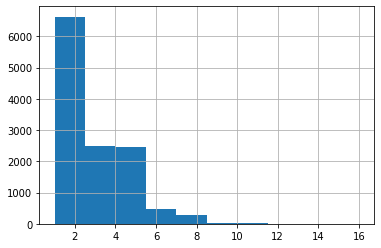

In [26]:
data.genrelist_length.hist(bins = 10)

Nonlinear scaling seems to be helpful!

In [27]:
data['length_scaled'] = np.power(data['genrelist_length']/data['genrelist_length'].max(), .25)

In [28]:
data = data.drop(['artist','genrelist', 'genres_encoded_as_list', 'genrelist_length'], axis = 1)


In [29]:
data.head()

,gender,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72,length_scaled
artist_id,,,,,,,,,,,,,,,,,,,,,
0,0,1007,1431,794,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.658037
1,0,465,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
2,0,1442,1357,1004,809,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.707107
3,0,1426,359,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.594604
4,0,1186,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000


In [30]:
cols = ['gender','length_scaled']+['label_{}'.format(i) for i in range(73)]
cols
data = data[cols]

In [31]:
data.head()

,gender,length_scaled,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
0,0,0.658037,1007,1431,794,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.500000,465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.707107,1442,1357,1004,809,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.594604,1426,359,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.500000,1186,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
data.shape, data.dtypes

((12376, 75),
 gender             int64
 length_scaled    float64
 label_0            int64
 label_1            int64
 label_2            int64
                   ...   
 label_68           int64
 label_69           int64
 label_70           int64
 label_71           int64
 label_72           int64
 Length: 75, dtype: object)

Shuffle the data:

In [33]:
data = data.sample(frac = 1)

In [34]:
data_set_size = data.shape[0]

Now split into X,y DFs

In [35]:
y = data.pop('gender')
X = data.copy()

In [36]:
X.head()

,length_scaled,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
6510,0.594604,1007,1431,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7633,0.500000,1431,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2938,0.594604,1007,1426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
690,0.500000,1007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7258,0.500000,1431,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define Model

In [78]:
def create_model():
    loss_fcn = keras.losses.BinaryCrossentropy(from_logits=True)
    #lr = .001
    initial_lr = .001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_lr,
    decay_steps = 4000,
    decay_rate = .8,
    staircase = True
    )
    lam = .0001
    #opt = tfa.optimizers.AdamW(lr = lr, weight_decay = .001)
    opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    
    reg = tf.keras.regularizers.l2(lam)
    
    # the list input; use vocab_size+1 since 0 is saved to indicate no label
    list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
    embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 500, input_length = max_list_length, name = 'list_embed')(list_input)
    pool = layers.GlobalAveragePooling1D()(embed)
    # the length input
    length_input = layers.Input(shape = (1,), name = 'length_input')
    # concatenate two inputs
    x = layers.concatenate([pool, length_input])
    # add dense layers
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.concatenate([x, length_input])
    x = layers.Dropout(.4)(x)
    # bring length input back
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(32, activation = 'relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(32, activation = 'relu')(x)
    pred = layers.Dense(1, name = 'predictions')(x)

    model = keras.Model(inputs = [list_input, length_input], outputs = [pred])
    
    
    model.compile(loss=loss_fcn,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [79]:
# need to install pydot (pip) and graphviz (conda)
#keras.utils.plot_model(model, 'dnn_0_model_graph.png', show_shapes = True)

In [80]:
#model.summary()

### Train Model

In [81]:
X_values = X.values
y_values = y.values

X_0_train = X_values[:,0:1]
X_1_train = X_values[:,1:74]
y_train = np.asarray(y_values)

model = create_model()

history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=64,
                    epochs=30,
                    validation_split = .2,
                    verbose = 1
                    )

Epoch 1/30
155/155 [==============================] - 3s 17ms/step - loss: 0.6313 - accuracy: 0.6896 - val_loss: 0.6236 - val_accuracy: 0.6874
Epoch 2/30
155/155 [==============================] - 3s 17ms/step - loss: 0.6145 - accuracy: 0.6896 - val_loss: 0.5915 - val_accuracy: 0.6874
Epoch 3/30
155/155 [==============================] - 3s 17ms/step - loss: 0.5691 - accuracy: 0.6896 - val_loss: 0.5243 - val_accuracy: 0.6874
Epoch 4/30
155/155 [==============================] - 3s 17ms/step - loss: 0.5349 - accuracy: 0.6908 - val_loss: 0.5088 - val_accuracy: 0.6874
Epoch 5/30
155/155 [==============================] - 3s 17ms/step - loss: 0.5203 - accuracy: 0.6988 - val_loss: 0.5117 - val_accuracy: 0.6918
Epoch 6/30
155/155 [==============================] - 3s 17ms/step - loss: 0.5112 - accuracy: 0.6992 - val_loss: 0.5018 - val_accuracy: 0.6931
Epoch 7/30
155/155 [==============================] - 3s 17ms/step - loss: 0.5068 - accuracy: 0.7087 - val_loss: 0.5018 - val_accuracy: 0.7027

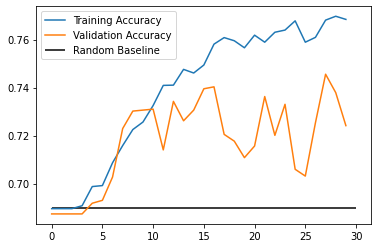

In [82]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.hlines(0.69,0,len(history.history['accuracy']), label = 'Random Baseline')
#plt.ylim(0,.1)
plt.legend()
plt.show()
#print(min(history.history['accuracy']))

Train with cross validation:

In [203]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

cvscores_acc = []

X_values = X.values
y_values = y.values

for train, test in kf.split(X_values,y_values):
    
    X_0_train = X_values[train,0:1]
    X_1_train = X_values[train,1:74]
    y_train = np.asarray(y_values[train])
    
    #print(X_0_train.shape, X_1_train.shape, y_train.shape)
    
    model = create_model()
    
#     dataset_length_train = tf.data.Dataset.from_tensor_slices((X_0_train, y_train)) 
#     dataset_list_train = tf.data.Dataset.from_tensor_slices((X_1_train, y_train)) 
    
    history = model.fit({'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    batch_size=16,
                    epochs=40,
                    verbose = 0 
                    )
    
    
    X_0_test = X_values[test,0:1]
    X_1_test = X_values[test,1:73]
    y_test = y_values[test]
    
#     dataset_length_test = tf.data.Dataset.from_tensor_slices((X_0_test, y_test)) 
#     dataset_list_test = tf.data.Dataset.from_tensor_slices((X_1_test, y_test)) 
    
    scores = model.evaluate(
                    {'list_input':X_1_train, 'length_input':X_0_train},
                    {'predictions':y_train},
                    verbose = 0)
    
    print(f'Accuracy = {scores[1]}.')
    cvscores_acc.append(scores[1])
    

print(f'Mean Accuracy is {np.mean(cvscores_acc):.4f} and STD of Accuracy is {np.std(cvscores_acc):.4f}')

Accuracy = 0.7739270925521851.
Accuracy = 0.7760818600654602.
Accuracy = 0.746453583240509.
Accuracy = 0.7574070692062378.
Accuracy = 0.7336146235466003.
Accuracy = 0.7557011842727661.
Accuracy = 0.7502468824386597.
Accuracy = 0.7313941717147827.
Accuracy = 0.7507855296134949.
Accuracy = 0.7415387630462646.
Mean Accuracy is 0.7517 and STD of Accuracy is 0.0142


Ignore for now: Another possibility: Create TF Dataset using the corpus from gensim as a generator: Another possibility: Create TF Dataset using the corpus from gensim as a generator:

In [ ]:
def corpus_gen():
    for i in len(corpus):
        yield (i, corpus[i])

In [ ]:
dataset = tf.data.Dataset.from_generator(
    corpus_gen,
    (tf.int64, --tensor_one_hot--)
)